# Regression Analysis

<br/>

- Regression Problem

- Analytical solution

- Regression results

- Applications to capital markets

In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
sns.set_style('whitegrid')
sns.set_context('poster', rc={"lines.linewidth": 2} )

%matplotlib inline

In [55]:
def gen_regression_problem(N, Vx, Ve, alpha, beta, mu=0, positive=False ):

    X = np.random.uniform(-Vx + mu, Vx + mu, N )
    E = np.random.normal(0, Ve, N )
    
    Y  = [ alpha + beta*x + e for x,e in zip(X,E) ]
    if positive: Y = np.abs(Y)
        
    df = pd.DataFrame({ 'X':X, 'Y':Y, 'E':E }).sort_values('X')  

    return df


def plot_reg(df, alpha=None, beta=None, w=[-6,6], h=[-6,6], prt=True):
    
    fig, (ax1) = plt.subplots(1,1, figsize=(10,4))
            
    _ = ax1.scatter(y=df['Y'], x=df['X'], marker='o', s=50, zorder=2 )
    _ = ax1.set_xlim(w)
    _ = ax1.set_ylim(h)
    
    if beta is not None: 
        
        df['Y1' ] = df['X'].apply( lambda x : alpha + beta * x )
        df['err'] = df['Y'] - df['Y1']
        SS_res    = (df['err']**2).sum()
        if prt:    
            print( 'alpha = {0:1.1f}, beta = {1:1.1f}'.format(alpha, beta) )
            print('Sum of Squared Residuals : {0:1.2f}'.format(SS_res)  )

        plot_fitted_line(alpha, beta, ax1, w)
                
        for i in range(0,len(df)):
            P1 = [ df['X' ].iloc[i], df['X'].iloc[i] ]
            P2 = [ df['Y1'].iloc[i], df['Y'].iloc[i] ]
            ax1.plot(P1, P2, color='r', alpha=0.5, zorder=1)
       
    

def plot_fitted_line(alpha, beta, ax, w=[-6,6]):
    f   = lambda x : alpha + beta * x
    dom = np.linspace(*w)
    img = list( map( f, dom ) )
    ax.plot(dom, img, color='k', linestyle='--')

def show_dataset():
    df = gen_regression_problem(50, 10, 75, 0, 25, mu=10, positive=True )
    plot_reg(df, w=[0, 20], h=[0,600])
    return df
    
def fit_dataset(df, prt=True):
    X1  = sm.add_constant(df[['X']]) 
    reg = sm.OLS( df['Y'], X1 ).fit()
    plot_reg(df, reg.params['const'], reg.params['X'], w=[0, 20], h=[0,600], prt=prt)
    return reg

# Introduction

Imagine you bought a car and the seller told you that it can run for $35$ kilometer per liter of gasoline.

This seems to good to be true, so you decide to investigate the matter.

You start using your new car and every time you drive from a place to another you keep track of

$$ x_i = \text{ liters of gasoline consumed during trip } i $$

and

$$ y_i = \text{ length of trip } i \text{ in kilometers } $$

After some months you made $N=50$ trips and you have a dataset with $N$ observations in the form

$$ (x_i, y_i) \quad \text{ for } \quad i=1,\dots N $$

How can you use this data to check if you can actually drive for $35$ km with one liter of gasoline?

## Use linear regression!

It makes sense to conjecture a linear relation between liters and kilometers, so you assume a linear model of the form

$$ y_i = \alpha + \beta x_i + \varepsilon_i $$

Of course, you expect $\alpha = 0$ and $\beta>0$ (why?)

But the precise value of $\beta$ is an *empirical question*. 

Will it be close to $35$ or not?

This is how your dataset looks like on your notebook:

![Notebook](Notebook.png "Notebook")

You can also plot it on the (x,y) plane:

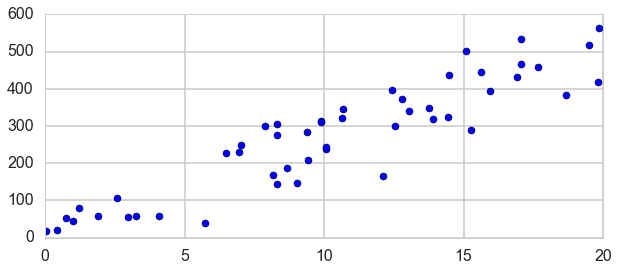

In [38]:
car_data = show_dataset()

You fit a linear regression to estimate the coefficients

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,16.1623,18.013,0.897,0.374,-20.055 52.380
X,24.8289,1.548,16.036,0.000,21.716 27.942


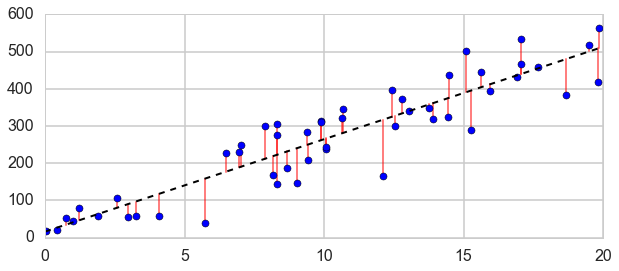

In [39]:
reg = fit_dataset(car_data, prt=False)
reg.summary().tables[1]

According to the estimate, the car can run for only 25 km with a liter of gasoline.
The seller was lying!

<br/><br/><br/><br/>

# Regression Problem

We are given $N$ points $(y_i, x_i)$ with $i=1,\dots N$.

We can think of those as sample draws from the the joint distribution of two random variables $X$ and $Y$.

We want to check if there is a linear relation between $X$ and $Y$.

If that is the case, we should find a non-zero $\beta$ when estimating the linear model

$$ y_i = \alpha + \beta x_i + \varepsilon_i $$

# Geometric Interpretation

We can scatter our observations on the (x,y) plane

![Regression Problem](problem.png "Regression Problem")

We want the line that fits the points in the best possible way.

Then the **slope** of the line will be our estimted $\beta$, while its **intercept** will be our estimated $\alpha$.

The best fitting line is the one that is closer to most of the points.
![Fitted Line](fitted.png "Fitted Line")

More precisely, it is the line with intercept $\alpha$ and slope $\beta$ which minimizes the **sum of squared residuals**, also known as $SS_{res}$

$$ SS_{res} = \sum_{i=1}^N \varepsilon_i^2 =  \sum_{i=1}^N ( y_i - \alpha - \beta x_i )^2 $$

<br/><br/><br/><br/>

# Examples

In [56]:
N  =  20; al =  1; be =  0.5; Vx =  4; Ve =  1

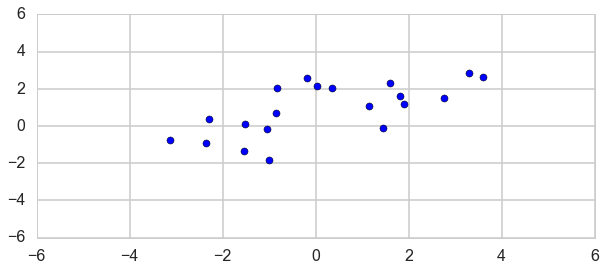

In [57]:
df  = gen_regression_problem(N, Vx, Ve, al, be )
plot_reg(df)

# First guess

alpha = 2.0, beta = -0.5
Sum of Squared Residuals : 113.20


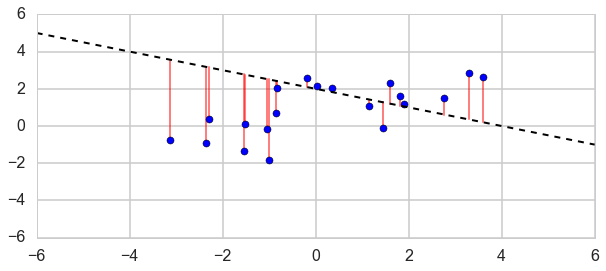

In [58]:
alpha = 2
beta  = -0.5
plot_reg(df, alpha, beta)

Not good at all! The slope of the line $\beta$ should be positive

# Second guess

alpha = 2.5, beta = 0.7
Sum of Squared Residuals : 82.55


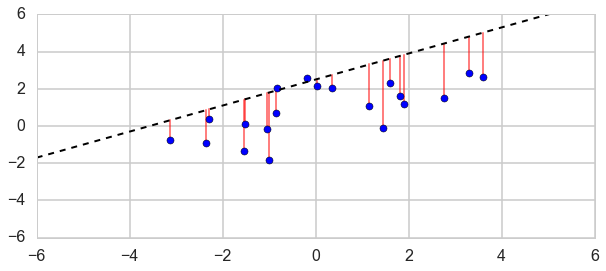

In [59]:
alpha = 2.5
beta  = 0.7
plot_reg(df, alpha, beta)

Better, but the $\alpha$ is too high

# Third guess

alpha = 1.0, beta = 0.7
Sum of Squared Residuals : 25.03


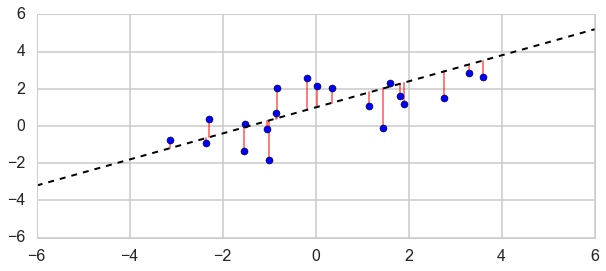

In [60]:
alpha =  1
beta  =  0.7
plot_reg(df, alpha, beta)

Not bad! But can we do better?

<br/><br/><br/><br/>

# Analytical Solution

We want to minimize the sum of squared resuduals, $SS_{res}$ , as a funcion of $\alpha$ and $\beta$. How?

#### Let's take derivatives!

First, we impose the FOC with respect to $\alpha$ and we get

$$ 
0 = \frac{\partial}{\partial \alpha}SS_{res} 
\implies 
\alpha = \frac{1}{N} \sum_{i=1}^N y_i - \frac{\beta}{N} \sum_{i=1}^N x_i 
= \bar{y} - \beta \bar{x}
$$

Thus we can rewritve $SS_{res}$ as 

$$ SS_{res} = \sum_{i=1}^N \left( y_i - \bar{y} - \beta (x_i-\bar{x}) \right)^2 $$

and imposing the FOC wrt $\beta$ we find

$$ 
\beta = \frac{ \frac{1}{N} \sum_i (y_i - \bar{y})(x_i -\bar{x}) } { \frac{1}{N} \sum_i (x_i -\bar{x})^2 }
= \frac{ \hat{Cov}(X,Y) } { \hat{V}(X) }
$$

Hence we see that the optimal $\beta$ is the sample covariance of $X$ and $Y$ divided by the sample variance of the explanatory variable $X$.

### Optimal $\alpha$ and $\beta$

alpha = 0.8, beta = 0.5
Sum of Squared Residuals : 20.97


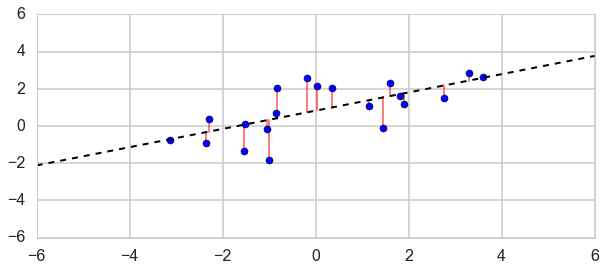

In [64]:
X1    = sm.add_constant(df[['X']])  # Define the explanatory variable
reg   = sm.OLS( df['Y'], X1 ).fit() # Fit the regression
alpha = reg.params['const']         # Estimated alpha
beta  = reg.params['X']             # Estimated beta
plot_reg(df, alpha, beta)

<br/><br/><br/><br/>

# $R^2$

The $R^2$ or **coefficient of determination** is the proportion of the variance of $Y$ that is predictable from $X$.

In other words it measures how well $X$ can explain $Y$.

To define the $R^2$ we first need to introduce two objects:

1. The total sum of squares $SS_{tot}$
<br/><br/>
2. The regression sum of squares $SS_{reg}$

The total sum of squares $SS_{tot}$ is proportional to the sample variance of $Y$

$$ SS_{tot} = \frac{1}{N-1} \sum_{i=1}^N (y_i - \bar{y})^2 = \hat{V}(Y) $$ 

This is the variation we would like to explain using the explanatory variable $X$.

The *regression sum of squares* or *explained sum of squares* $SS_{tot}$ is proportional to the sample variance of $\beta X$

$$ SS_{reg} = \frac{1}{N-1} \sum_{i=1}^N (\beta x_i - \beta \bar{x})^2 = \hat{V}(\beta X) $$

This is the variation we can explain using the explanatory variable $X$.

The coefficient of determination or $R^2$ is defined as 

$$ R^2 = \frac{SS_{tot} - SS_{reg}}{SS_{tot}} $$

It measures the fraction of variance that can be explained by $X$

# Significance of $\beta$

When we estimate a model on the data, we want a way to measure the statistical significance of the estimated parameters.

...

The *standard error* of $\beta$ is the standard deviation of the fitted $\beta$, given $X$. 

Since $V(y_i \mid X) =  V(\varepsilon)$, we find

$$ V(\beta \mid X) 
= V\left( \frac{ \sum_i (y_i - \bar{y})(x_i -\bar{x}) } { \sum_i (x_i -\bar{x})^2 } \mid X \right)
= \frac{ V(\varepsilon) } { \sum_i (x_i -\bar{x})^2 }
= \frac{1}{(N-1)} \frac{ V(\varepsilon) } { \hat{V}(X) }
$$

Therefore an empirical estimate of the standard error of $\beta$ is

$$ SE(\beta) = \sqrt{ \frac{\hat{V}(\varepsilon)}{ (N-1) \hat{V}(X)} } $$

The intuition is the following:

- The standard error of $\beta$ is the ratio between the sample volatility of $\varepsilon$ and the sample volatility of $X$
- When this ratio is large, it means that *points are stacked together in a small space*
- Thus, if the $SE(\beta)$ is too large, it means that our estimate of $\beta$ is *unstable*

The *t-statistics* is defined as the ratio

$$ \frac{\beta}{SE(\beta)} $$ 

If the t-stat is far enough from zero, then we say that the estimated $\beta$ is significantly different from zero.

The threshold for significance depends on the number of explanatory variables in our linear model.

A more practical way to check if an estimated coefficient is significantly different from zero is to look at the p-value.

It is computed from the t-stat and it (roughly) gives the probability that the estimated coefficient is non-zero even if the real coefficient is zero (false positive).

The thresholds are fixed by convention as:
- p-value $\geq 5  \% \quad \implies \quad $ not significantly different from zero
- p-value $ <   5  \% \quad \implies \quad $ weakly significant
- p-value $ <   1  \% \quad \implies \quad $ significant
- p-value $ <   0.1\% \,\,  \implies \quad $ highly significant

<br/><br/><br/><br/>

## Coefficients

In [53]:
df  = gen_regression_problem(20, 4, 0.75, 0.2, -1 )

X1  = sm.add_constant(df[['X']]) 
reg = sm.OLS( df['Y'], X1 ).fit()

alpha = reg.params['const']  # Estimated alpha
beta  = reg.params['X']      # Estimated beta

alpha = 0.8, beta = 0.5
Sum of Squared Residuals : 20.97


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,0.8248,0.242,3.406,0.003,0.316 1.334
X,0.4906,0.126,3.881,0.001,0.225 0.756


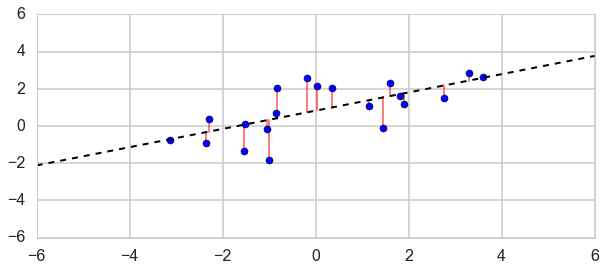

In [68]:
plot_reg(df, alpha, beta)
reg.summary().tables[1]

alpha = -1.0, beta = 0.2
Sum of Squared Residuals : 16.77


,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-1.0424,0.221,-4.717,0.000,-1.507 -0.578
X,0.1595,0.107,1.492,0.153,-0.065 0.384


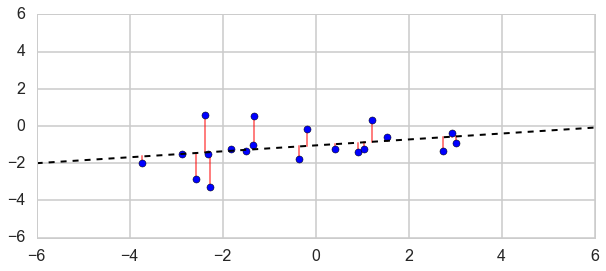

In [73]:
# Small Beta
df  = gen_regression_problem(20, 4, 1, -1, 0.2 )
reg = sm.OLS( df['Y'], sm.add_constant(df[['X']])  ).fit()
plot_reg(df, reg.params['const'] , reg.params['X'])
reg.summary().tables[1]

### Low $R^2$

alpha = -0.2, beta = 0.4
Sum of Squared Residuals : 859.18


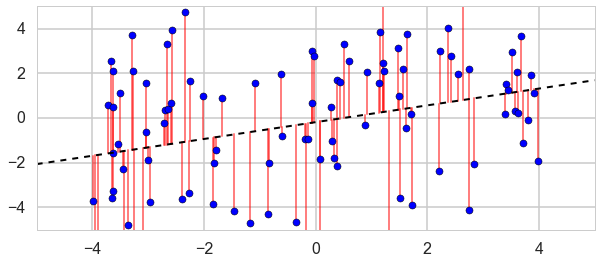

In [15]:
N  =  100
al =  0.2
be =  0.5
Vx =  4
Ve =  3

df  = gen_regression_problem(N, Vx, Ve, al, be )

X1  = sm.add_constant(df[['X']]) 
reg = sm.OLS( df['Y'], X1 ).fit()

alpha = reg.params['const']  # Estimated alpha
beta  = reg.params['X']      # Estimated beta
plot_reg(df, alpha, beta)

In [16]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     10.06
Date:                Tue, 08 Nov 2016   Prob (F-statistic):            0.00203
Time:                        22:31:12   Log-Likelihood:                -249.43
No. Observations:                 100   AIC:                             502.9
Df Residuals:                      98   BIC:                             508.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.1868      0.298     -0.627      0.532        -0.778     0.404
X              0.3762      0.119      3.171      0.002         0.141     0.612
==============================================================================
Omnibus:                        3.378   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                3.055
Skew:                          -0.345   Prob(JB):                        0.217
Kurtosis:                       2.493   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### High $R^2$

alpha = 0.1, beta = 0.5
Sum of Squared Residuals : 22.69


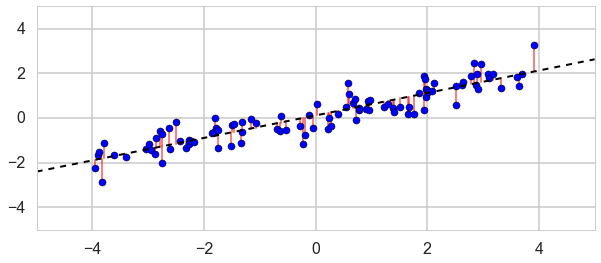

In [17]:
N  =  100
al =  0.2
be =  0.5
Vx =  4
Ve =  0.5

df  = gen_regression_problem(N, Vx, Ve, al, be )

X1  = sm.add_constant(df[['X']]) 
reg = sm.OLS( df['Y'], X1 ).fit()

alpha = reg.params['const']  # Estimated alpha
beta  = reg.params['X']      # Estimated beta
plot_reg(df, alpha, beta)

In [18]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     535.4
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           1.70e-41
Time:                        22:31:14   Log-Likelihood:                -67.731
No. Observations:                 100   AIC:                             139.5
Df Residuals:                      98   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1147      0.048      2.385      0.019         0.019     0.210
X              0.5030      0.022     23.138      0.000         0.460     0.546
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.141
Skew:                           0.061   Prob(JB):                        0.932
Kurtosis:                       2.862   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Highly Significant $\beta$

alpha = 0.3, beta = 0.5
Sum of Squared Residuals : 142.26


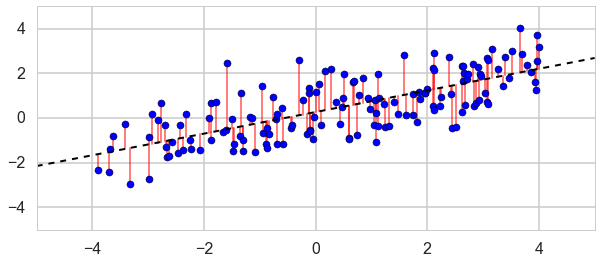

In [19]:
N  =  150
al =  0.2
be =  0.5
Vx =  4
Ve =  1

df  = gen_regression_problem(N, Vx, Ve, al, be )

X1  = sm.add_constant(df[['X']]) 
reg = sm.OLS( df['Y'], X1 ).fit()

alpha = reg.params['const']  # Estimated alpha
beta  = reg.params['X']      # Estimated beta
plot_reg(df, alpha, beta)

In [20]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     165.8
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           6.34e-26
Time:                        22:31:16   Log-Likelihood:                -208.87
No. Observations:                 150   AIC:                             421.7
Df Residuals:                     148   BIC:                             427.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2682      0.082      3.259      0.001         0.106     0.431
X              0.4841      0.038     12.875      0.000         0.410     0.558
==============================================================================
Omnibus:                        4.540   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.145
Skew:                           0.336   Prob(JB):                        0.126
Kurtosis:                       2.540   Cond. No.                         2.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Not Significant $\beta$

alpha = 0.4, beta = -0.5
Sum of Squared Residuals : 217.63


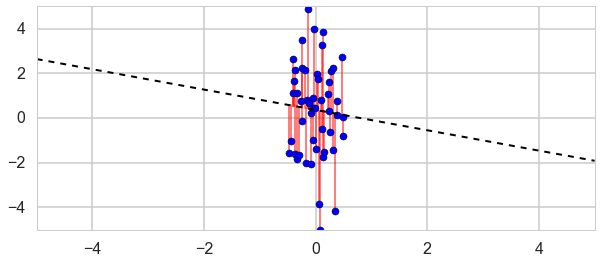

In [21]:
N  =  50
al =  0.2
be =  0.5
Vx =  0.5
Ve =  2

df  = gen_regression_problem(N, Vx, Ve, al, be )

X1  = sm.add_constant(df[['X']]) 
reg = sm.OLS( df['Y'], X1 ).fit()

alpha = reg.params['const']  # Estimated alpha
beta  = reg.params['X']      # Estimated beta
plot_reg(df, alpha, beta)

In [22]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1646
Date:                Tue, 08 Nov 2016   Prob (F-statistic):              0.687
Time:                        22:31:17   Log-Likelihood:                -107.72
No. Observations:                  50   AIC:                             219.4
Df Residuals:                      48   BIC:                             223.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3620      0.301      1.201      0.236        -0.244     0.968
X             -0.4556      1.123     -0.406      0.687        -2.714     1.802
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.548
Skew:                          -0.248   Prob(JB):                        0.760
Kurtosis:                       2.869   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br/><br/><br/><br/>

# Capital Markets

In [23]:
data = pd.read_csv('CRSP.csv',
                   parse_dates=['date'], 
                   infer_datetime_format=True,
                   na_values='C'
                  )
data.columns = list( map( lambda x : x.lower(), data.columns) )
data.rename_axis({'comnam':'asset', 'sprtrn':'market'}, inplace=1, axis=1)
data = data.set_index('date')

class Stock:
    def __init__( self, permno, color, data=data ):
        self.permno = permno
        self.color  = color
        self.mask   = (data['permno']==permno)
        self.name   = data[self.mask]['asset'].iloc[0]
        
CocaCola     = Stock( 11308, sns.xkcd_rgb['red']  )
Apple        = Stock( 14593, sns.xkcd_rgb['denim blue'] )
PhilipMorris = Stock( 92602, sns.xkcd_rgb['dark grey'] )
Tesla        = Stock( 93436, sns.xkcd_rgb['teal'] )
Google       = Stock( 90319, sns.xkcd_rgb['teal'] )
Microsoft    = Stock( 10107, sns.xkcd_rgb['teal'] )
Amazon       = Stock( 84788, sns.xkcd_rgb['teal'] )
Sony         = Stock( 51131, sns.xkcd_rgb['teal'] )

def CAPM_reg(stock, period=None):
    df = data[stock.mask].dropna()
    if period is not None: 
        df = df[df.index.isin(period)]
    y  = df['ret'] 
    x  = sm.add_constant(df['market'] )
    return sm.OLS(y,x).fit()

In [24]:
data.groupby(['asset', 'permno']).first()

,,prc,vol,ret,shrout,market
asset,permno,,,,,
ALPHABET INC,90319,671.67999,1898462,0.022360,291214,0.018290
AMAZON COM INC,84788,38.70000,12450246,-0.019260,414000,-0.001199
APPLE COMPUTER INC,14593,83.80000,44545733,-0.012258,860220,-0.001199
APPLE INC,14593,95.80000,51550184,-0.012371,860220,0.006340
COCA COLA CO,11308,48.58000,7877300,0.006839,2343796,-0.001199
GOOGLE INC,90319,467.59000,7725290,0.015440,227670,-0.001199
MICROSOFT CORP,10107,29.86000,77630458,0.000000,9777000,-0.001199
PHILIP MORRIS INTERNATIONAL INC,92602,50.58000,19414200,0.000000,2108301,0.005687
SONY CORP,51131,42.91000,1200600,0.001868,143380,-0.001199


In [25]:
reg = CAPM_reg(Amazon)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     1055.
Date:                Tue, 08 Nov 2016   Prob (F-statistic):          2.66e-190
Time:                        22:31:19   Log-Likelihood:                 5420.5
No. Observations:                2266   AIC:                        -1.084e+04
Df Residuals:                    2264   BIC:                        -1.083e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0013      0.000      2.844      0.004         0.000     0.002
market         1.1092      0.034     32.480      0.000         1.042     1.176
==============================================================================
Omnibus:                     1672.764   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107939.317
Skew:                           2.868   Prob(JB):                         0.00
Kurtosis:                      36.322   Cond. No.                         73.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br/><br/><br/><br/>

# Neutralize the market risk

We saw that Amazon had a significant alpha over the sample.
Suppose we run some fundamental studies and we were able to predict it.
How can we bet on the alpha, neutralizing market risk?

The estimated beta of Amazon is 1.1. Assume we also knew this beforehand.

Hence, we can form a portfolio which is long Amazon and short the market in the right proportions.

In [74]:
w_A = 1
w_M = -1.11
pf_return    = w_A * data[Amazon.mask]['ret']
pf_return   += w_M * data.groupby(level=0).first()['market']

pf = pd.DataFrame( {'ret':pf_return} )
pf['market'] = data.groupby(level=0).first()['market']

y  = pf['ret'] 
x  = sm.add_constant(pf['market'] )
sm.OLS(y,x).fit().summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,0.0013,0.000,2.844,0.004,0.000 0.002
market,-0.0008,0.034,-0.022,0.982,-0.068 0.066


The alpha is positive and significant, while the market beta is not significantly different from zero.

With this strategy we are able to pocket the alpha, without being exposed to the market risk.

### More fair : estimate the market beta ex-ante
Suppose we want to implement the strategy starting from January 2009.

We estimate the market beta in a backward-looking window, say during the previous quarter.

In [27]:
estimation_window = pd.date_range( pd.datetime(2008,10,1), pd.datetime(2008,12,31) )
investment_window = pd.date_range( pd.datetime(2009,1 ,1), pd.datetime(2015,12,31) )

reg = CAPM_reg(Amazon, estimation_window)
reg.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-0.0005,0.004,-0.115,0.909,-0.009 0.008
market,1.0891,0.099,11.034,0.000,0.892 1.286


The estimated beta is 1.0891. Let's build our portfolio

In [28]:
w_A = 1
w_M = -1.0891

pf_return    = w_A * data[Amazon.mask]['ret']
pf_return   += w_M * data.groupby(level=0).first()['market']

pf = pd.DataFrame( {'ret':pf_return} )
pf['market'] = data.groupby(level=0).first()['market']

pf = pf[pf.index.isin(investment_window)]

y  = pf['ret'] 
x  = sm.add_constant(pf['market'] )
sm.OLS(y,x).fit().summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,0.0012,0.000,2.512,0.012,0.000 0.002
market,-0.0667,0.041,-1.607,0.108,-0.148 0.015


Good! We still get the alpha and the market exposure is not significant.

<br/><br/><br/><br/>

# Multivariate Regression : Boston house prices

In [29]:
from sklearn import datasets
boston = datasets.load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['price'] = boston.target
boston.DESCR

y = df['price']
x = sm.add_constant(df[['RM','CRIM', 'AGE', 'INDUS']])
sm.OLS(y,x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     166.0
Date:                Tue, 08 Nov 2016   Prob (F-statistic):           2.22e-90
Time:                        22:31:30   Log-Likelihood:                -1626.7
No. Observations:                 506   AIC:                             3263.
Df Residuals:                     501   BIC:                             3285.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -21.0523      2.887     -7.292      0.000       -26.725   -15.380
RM             7.6751      0.418     18.359      0.000         6.854     8.496
CRIM          -0.1860      0.035     -5.365      0.000        -0.254    -0.118
AGE           -0.0317      0.013     -2.506      0.013        -0.056    -0.007
INDUS         -0.1626      0.056     -2.929      0.004        -0.272    -0.054
==============================================================================
Omnibus:                      241.916   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1914.083
Skew:                           1.921   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                         817.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br/><br/><br/><br/>